## Imports

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import matplotlib.pyplot as plt

## Preparing the dataset

In [2]:
splits, info = tfds.load('horses_or_humans', as_supervised=True, with_info=True, split=['train[:80%]', 'train[80%:]', 'test'], data_dir='./data')

(train_examples, validation_examples, test_examples) = splits

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/1027 [00:00<?, ? examples/s]

Shuffling data/horses_or_humans/incomplete.4TSQ6R_3.0.0/horses_or_humans-train.tfrecord*...:   0%|          | …

Generating test examples...:   0%|          | 0/256 [00:00<?, ? examples/s]

Shuffling data/horses_or_humans/incomplete.4TSQ6R_3.0.0/horses_or_humans-test.tfrecord*...:   0%|          | 0…

Dataset horses_or_humans downloaded and prepared to ./data/horses_or_humans/3.0.0. Subsequent calls will reuse this data.


In [3]:
BATCH_SIZE = 32
IMAGE_SIZE = 224


## Image Preprocessing

In [4]:
# Autograph pre-processing function to resize and normalize an image

@tf.function
def map_fn(img, label):
    image_height = 224
    image_width = 224

    # resize the image
    img = tf.image.resize(img, [image_height, image_width])
    # normalize the image
    img /= 255.

    return img, label

In [5]:
# Prepare train dataset by using preprocessing with map_fn, shuffling and batching
def prepare_dataset(train_examples, validation_examples, test_examples, num_examples, map_fn, batch_size):
    train_ds = train_examples.map(map_fn).shuffle(buffer_size=num_examples).batch(batch_size)
    valid_ds = validation_examples.map(map_fn).batch(batch_size)
    test_ds = test_examples.map(map_fn).batch(batch_size)

    return train_ds, valid_ds, test_ds

In [6]:
train_ds, valid_ds, test_ds = prepare_dataset(train_examples, validation_examples, test_examples, num_examples, map_fn, BATCH_SIZE)

## Defining the Model

In [21]:
import kagglehub

# Download latest version of resnet feature-vector
path = kagglehub.model_download("tensorflow/resnet-50/tensorFlow2/feature-vector")

print("Path to model files:", path)

Path to model files: /root/.cache/kagglehub/models/tensorflow/resnet-50/tensorFlow2/feature-vector/1


In [23]:
MODULE_HANDLE = path
model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: hub.KerasLayer(MODULE_HANDLE)(x), input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/lambda_layer.py:65: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lambda (Lambda)                      │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │           4,098 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,098 (16.01 KB)

 Trainable params: 4,098 (16.01 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
def set_adam_optimizer():

    # Define the adam optimizer
    optimizer = tf.keras.optimizers.Adam()

    return optimizer

## Defining the loss function

In [25]:
def set_sparse_cat_crossentropy_loss():
    # Define object oriented metric of Sparse categorical crossentropy for train and val loss
    train_loss = tf.keras.losses.SparseCategoricalCrossentropy()
    val_loss = tf.keras.losses.SparseCategoricalCrossentropy()
    return train_loss, val_loss

## Defining the accuracy function

In [26]:
def set_sparse_cat_crossentropy_accuracy():

    # Define object oriented metric of Sparse categorical accuracy for train and val accuracy
    train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
    val_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

    return train_accuracy, val_accuracy

In [27]:
optimizer = set_adam_optimizer()
train_loss, val_loss = set_sparse_cat_crossentropy_loss()
train_accuracy, val_accuracy = set_sparse_cat_crossentropy_accuracy()

## The Training Loop

In [28]:
# this code uses the GPU if available, otherwise uses a CPU
device = '/gpu:0' if tf.test.is_gpu_available() else '/cpu:0'
EPOCHS = 2

# Custom training step
def train_one_step(model, optimizer, x, y, train_loss, train_accuracy):
    '''
    Trains on a batch of images for one step.

    Args:
        model (keras Model) -- image classifier
        optimizer (keras Optimizer) -- optimizer to use during training
        x (Tensor) -- training images
        y (Tensor) -- training labels
        train_loss (keras Loss) -- loss object for training
        train_accuracy (keras Metric) -- accuracy metric for training
    '''
    with tf.GradientTape() as tape:
        # Run the model on input x to get predictions
        predictions = model(x)
        # Compute the training loss using `train_loss`, passing in the true y and the predicted y
        loss = train_loss(y, predictions)

    # Using the tape and loss, compute the gradients on model variables using tape.gradient
    grads = tape.gradient(loss, model.trainable_weights)

    # Zip the gradients and model variables, and then apply the result on the optimizer
    optimizer.apply_gradients(zip(grads, model.trainable_weights))

    # Call the train accuracy object on ground truth and predictions
    train_accuracy.update_state(y, predictions)

    return loss

## The Train function

In [29]:
# Decorate this function with tf.function to enable autograph on the training loop
@tf.function
def train(model, optimizer, epochs, device, train_ds, train_loss, train_accuracy, valid_ds, val_loss, val_accuracy):
    '''
    Performs the entire training loop. Prints the loss and accuracy per step and epoch.

    Args:
        model (keras Model) -- image classifier
        optimizer (keras Optimizer) -- optimizer to use during training
        epochs (int) -- number of epochs
        train_ds (tf Dataset) -- the train set containing image-label pairs
        train_loss (keras Loss) -- loss function for training
        train_accuracy (keras Metric) -- accuracy metric for training
        valid_ds (Tensor) -- the val set containing image-label pairs
        val_loss (keras Loss) -- loss object for validation
        val_accuracy (keras Metric) -- accuracy metric for validation
    '''
    step = 0
    loss = 0.0
    for epoch in range(epochs):
        for x, y in train_ds:
            # training step number increments at each iteration
            step += 1
            with tf.device(device_name=device):
                # Run one training step by passing appropriate model parameters
                # required by the function and finally get the loss to report the results
                loss = train_one_step(model, optimizer, x, y, train_loss, train_accuracy)
            # Use tf.print to report your results.
            # Print the training step number, loss and accuracy
            tf.print('Step', step,
                   ': train loss', loss,
                   '; train accuracy', train_accuracy.result())

        with tf.device(device_name=device):
            for x, y in valid_ds:
                # Call the model on the batches of inputs x and get the predictions
                y_pred = model(x)
                loss = val_loss(y, y_pred)
                val_accuracy(y, y_pred)

        # Print the validation loss and accuracy
        tf.print('val loss', loss, '; val accuracy', val_accuracy.result())

In [30]:
train(model, optimizer, EPOCHS, device, train_ds, train_loss, train_accuracy, valid_ds, val_loss, val_accuracy)

Step 1 : train loss 0.966334343 ; train accuracy 0.34375
Step 2 : train loss 0.933383882 ; train accuracy 0.40625
Step 3 : train loss 0.665080667 ; train accuracy 0.479166657
Step 4 : train loss 0.421432257 ; train accuracy 0.5625
Step 5 : train loss 0.287780881 ; train accuracy 0.6375
Step 6 : train loss 0.294205129 ; train accuracy 0.671875
Step 7 : train loss 0.224579737 ; train accuracy 0.714285731
Step 8 : train loss 0.196718246 ; train accuracy 0.7421875
Step 9 : train loss 0.0720749944 ; train accuracy 0.770833313
Step 10 : train loss 0.0994465798 ; train accuracy 0.79375
Step 11 : train loss 0.0641318709 ; train accuracy 0.8125
Step 12 : train loss 0.0412938036 ; train accuracy 0.828125
Step 13 : train loss 0.0359226242 ; train accuracy 0.841346145
Step 14 : train loss 0.0492616147 ; train accuracy 0.852678597
Step 15 : train loss 0.12209893 ; train accuracy 0.860416651
Step 16 : train loss 0.0336586572 ; train accuracy 0.869140625
Step 17 : train loss 0.0392985865 ; train accu

## Evaluation

In [31]:
test_imgs = []
test_labels = []

predictions = []
with tf.device(device_name=device):
    for images, labels in test_ds:
        preds = model(images)
        preds = preds.numpy()
        predictions.extend(preds)

        test_imgs.extend(images.numpy())
        test_labels.extend(labels.numpy())

In [32]:
# Utilities for plotting

class_names = ['horse', 'human']

def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    img = np.squeeze(img)

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)

    # green-colored annotations will mark correct predictions. red otherwise.
    if predicted_label == true_label:
        color = 'green'
    else:
        color = 'red'

    # print the true label first
    print(true_label)

    # show the image and overlay the prediction
    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)


0


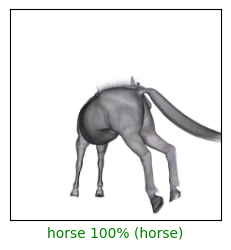

0


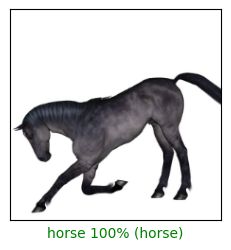

0


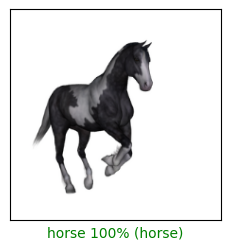

1


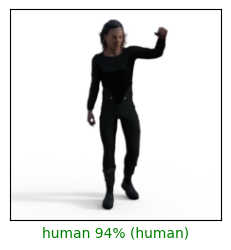

1


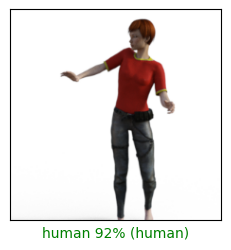

0


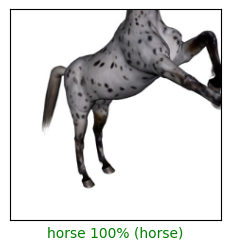

0


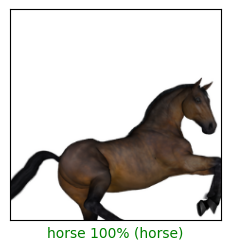

1


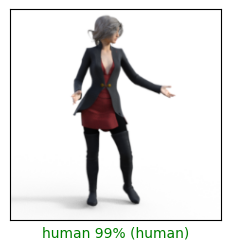

0


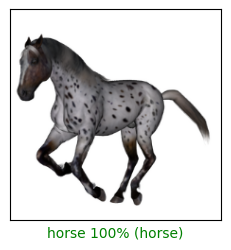

1


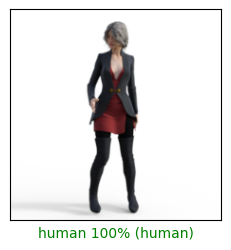

0


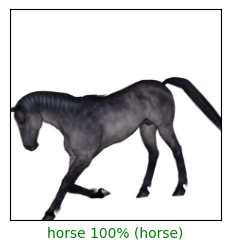

1


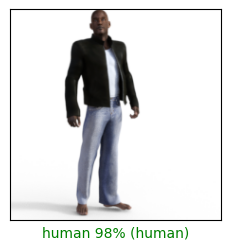

1


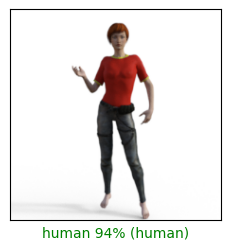

0


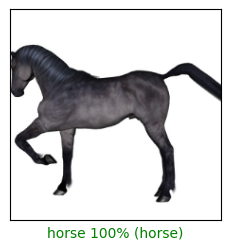

1


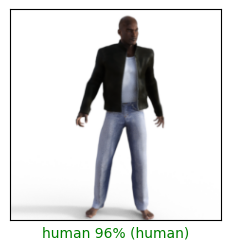

0


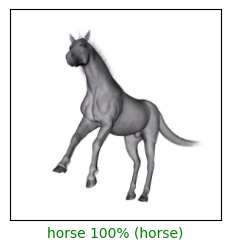

0


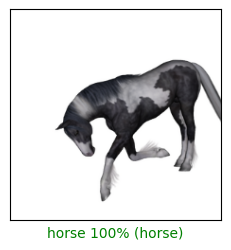

1


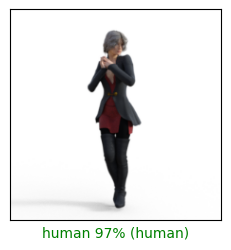

0


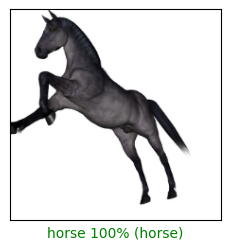

1


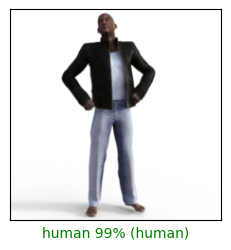

0


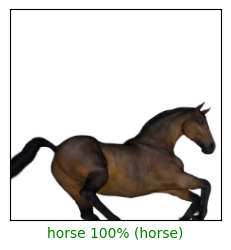

1


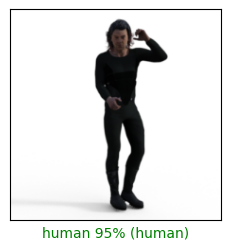

0


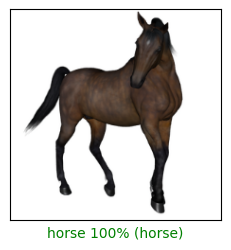

0


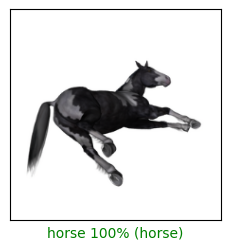

0


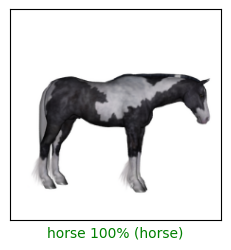

In [33]:
# Visualize the outputs

for index in range(25):
  plt.figure(figsize=(6,3))
  plt.subplot(1,2,1)
  plot_image(index, predictions, test_labels, test_imgs)
  plt.show()